In [ ]:
import os
import torch
import torch.nn as nn
from PIL import Image
from PIL import ImageOps
from src.training import fit
import torchinfo as torchinfo
from src.evaluation import evaluate_model
from collections import Counter
from torchvision import datasets, transforms
from src.training import plot_train_results_from_json
from torchvision.models import resnet50, ResNet50_Weights
from torch.utils.data import DataLoader, WeightedRandomSampler

# USAR GPU SI ES POSIBLE
device = "cuda" if torch.cuda.is_available() else "cpu"

# Path de descarga de datasets usando KaggleHub
os.environ["KAGGLEHUB_CACHE"] = "./"

# PARAMETROS GLOBALES
BATCH_SIZE = 64
WORKERS = 4
DATASET_AUGMENTED_SIZE = 4000

print(f'Dispositivo a utilizar: {device}')

Dispositivo a utilizar: cuda


In [2]:
# Directorio raíz del dataset
root_dir = "./data/dataset"

# Inicializamos contador
channel_counter = Counter()
errors = []

# Recorremos todas las imágenes
for split in ["train", "valid", "test"]:
    split_path = os.path.join(root_dir, split)
    for class_name in os.listdir(split_path):
        class_dir = os.path.join(split_path, class_name)
        if not os.path.isdir(class_dir):
            continue
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            try:
                with Image.open(img_path) as img:
                    channel_counter[img.mode] += 1
            except Exception as e:
                errors.append((img_path, str(e)))

# Resultados
print("Cantidad de imágenes por tipo de canal (modo):")
for mode, count in channel_counter.items():
    print(f"  {mode}: {count} imágenes")

if errors:
    print("\n⚠️ Errores al abrir algunas imágenes:")
    for path, err in errors:
        print(f"  {path} -> {err}")

Cantidad de imágenes por tipo de canal (modo):
  RGBA: 923 imágenes
  RGB: 74 imágenes
  L: 3 imágenes


In [3]:
class ResizeWithAspectRatioPadding:
    """
    Clase para redimensionar imágenes manteniendo el aspecto y rellenando con ceros (padding).
    """
    def __init__(self, target_size):
        self.target_size = target_size

    def __call__(self, img):
        # Convertimos a tamaño cuadrado manteniendo aspecto
        old_width, old_height = img.size
        ratio = min(self.target_size[0] / old_width, self.target_size[1] / old_height)
        new_size = (int(old_width * ratio), int(old_height * ratio))
        img = img.resize(new_size, resample=Image.BILINEAR)

        delta_w = self.target_size[0] - new_size[0]
        delta_h = self.target_size[1] - new_size[1]
        padding = (delta_w // 2, delta_h // 2, delta_w - delta_w // 2, delta_h - delta_h // 2)
        img = ImageOps.expand(img, padding, fill=0)

        return img

In [4]:
# Paso previo obligatorio: transformar todo a RGB
to_rgb = transforms.Lambda(lambda img: img.convert("RGB"))

# Tamaño objetivo (input para ResNet)
image_size = (224, 224)

# 1- Se aplican distintas transformaciones para el dataset de train y test
# Transform para train (con augmentations)
train_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1),  # Augmentations suaves
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para valid (sin augmentations, con resize)
valid_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Transform para test (idéntico a valid)
test_transform = transforms.Compose([
    to_rgb,
    ResizeWithAspectRatioPadding(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# 2- Se cargan los datasets de train y test con las transformaciones
train_dataset = datasets.ImageFolder(root='data/dataset' + '/train', transform=train_transform)
test_dataset = datasets.ImageFolder(root='data/dataset' + '/test', transform=test_transform)
valid_dataset = datasets.ImageFolder(root='data/dataset' + '/valid', transform=valid_transform)

# 3- Se splitea el dataset de train en train y validation para entrenamiento, test se deja para tarea final de evaluación
# Obtener las etiquetas de las imágenes en el dataset de entrenamiento
targets = [label for _, label in train_dataset]
class_counts = Counter(targets)
class_weights = {cls: len(targets) / count for cls, count in class_counts.items()}
sample_weights = torch.DoubleTensor([class_weights[label] for label in targets])

# 4 - Sampler balanceado
sampler = WeightedRandomSampler(
    weights=sample_weights,num_samples=DATASET_AUGMENTED_SIZE,replacement=True
)

# 5 - DataLoaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler, num_workers=WORKERS, pin_memory=True)
val_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=WORKERS, pin_memory=True)

# 6 - Info
print(f"Pesos por clase: {class_weights}")
print(f"Tamaño de train dataset original: {len(train_dataset)}")
print(f"Tamaño de train dataset con augmentation: {DATASET_AUGMENTED_SIZE}")
print(f"Tamaño de validation dataset: {len(valid_dataset)}")
print(f"Tamaño de test dataset: {len(test_dataset)}")

Pesos por clase: {0: 3.1435897435897435, 1: 5.3304347826086955, 2: 4.141891891891892, 3: 3.9548387096774196}
Tamaño de train dataset original: 613
Tamaño de train dataset con augmentation: 4000
Tamaño de validation dataset: 72
Tamaño de test dataset: 315


In [5]:
model = resnet50(weights=ResNet50_Weights.DEFAULT)
print(f'La arquitectura por default de ResNet-50 es la siguiente:\n\n{model}') 

La arquitectura por default de ResNet-50 es la siguiente:

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
 

In [6]:
torchinfo.summary(model, input_size=(1, 3, 224, 224), depth=3, col_names=["kernel_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Kernel Shape              Output Shape              Param #
ResNet                                   --                        [1, 1000]                 --
├─Conv2d: 1-1                            [7, 7]                    [1, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       --                        [1, 64, 112, 112]         128
├─ReLU: 1-3                              --                        [1, 64, 112, 112]         --
├─MaxPool2d: 1-4                         3                         [1, 64, 56, 56]           --
├─Sequential: 1-5                        --                        [1, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   --                        [1, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [1, 1]                    [1, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             --                        [1, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [7]:
def build_resnet50_transfer(num_classes: int = 4) -> nn.Module:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Congelar todos los parámetros
    for param in model.parameters():
        param.requires_grad = False

    # Descongelar solo la nueva fc
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

def build_resnet50_finetune(num_classes: int = 4) -> nn.Module:
    model = resnet50(weights=ResNet50_Weights.DEFAULT)

    # Reemplazar la capa fully connected final
    in_features = model.fc.in_features
    model.fc = nn.Linear(in_features, num_classes)

    # Congelar todo menos layer4 y fc
    for name, param in model.named_parameters():
        if name.startswith("layer4") or name.startswith("fc"):
            param.requires_grad = True
        else:
            param.requires_grad = False

    return model


In [ ]:
# Se remueve la capa fully connected final y se reemplaza por una nueva
# model = build_resnet50_transfer(num_classes=4)

# Se remueve la capa fully connected final y se reemplaza por una nueva. También
# se descongelan las capas de la última capa convolucional (layer4)
model = build_resnet50_finetune(num_classes=4)
model = model.to(device)

# Verificación
for name, param in model.named_parameters():
    if param.requires_grad:
        print(f"Entrenando: {name}")

Entrenando: layer4.0.conv1.weight
Entrenando: layer4.0.bn1.weight
Entrenando: layer4.0.bn1.bias
Entrenando: layer4.0.conv2.weight
Entrenando: layer4.0.bn2.weight
Entrenando: layer4.0.bn2.bias
Entrenando: layer4.0.conv3.weight
Entrenando: layer4.0.bn3.weight
Entrenando: layer4.0.bn3.bias
Entrenando: layer4.0.downsample.0.weight
Entrenando: layer4.0.downsample.1.weight
Entrenando: layer4.0.downsample.1.bias
Entrenando: layer4.1.conv1.weight
Entrenando: layer4.1.bn1.weight
Entrenando: layer4.1.bn1.bias
Entrenando: layer4.1.conv2.weight
Entrenando: layer4.1.bn2.weight
Entrenando: layer4.1.bn2.bias
Entrenando: layer4.1.conv3.weight
Entrenando: layer4.1.bn3.weight
Entrenando: layer4.1.bn3.bias
Entrenando: layer4.2.conv1.weight
Entrenando: layer4.2.bn1.weight
Entrenando: layer4.2.bn1.bias
Entrenando: layer4.2.conv2.weight
Entrenando: layer4.2.bn2.weight
Entrenando: layer4.2.bn2.bias
Entrenando: layer4.2.conv3.weight
Entrenando: layer4.2.bn3.weight
Entrenando: layer4.2.bn3.bias
Entrenando: fc.

In [ ]:
# Entrenamos el modelo (ResNet50)
fit(model, train_loader=train_loader, eval_loader=val_loader, epochs=20, model_name='data/resnet50_layer4_fc_weights.pth', results_file='data/resnet50_layer4_fc_train_results.json')   

val_loss 0.58699 val_acc 0.87500: 100%|██████████| 2/2 [00:00<00:00,  3.21it/s]


Epoch 1/20 loss 0.31169 val_loss 0.58699 acc 0.87649 val_acc 0.87500 train_f1 0.87567 val_f1 0.79473
Mejor modelo guardado en la época 1 con val_loss 0.58699
Mejor modelo guardado.


val_loss 0.43343 val_acc 0.85938: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Epoch 2/20 loss 0.05585 val_loss 0.43343 acc 0.98189 val_acc 0.85938 train_f1 0.98173 val_f1 0.84909
Mejor modelo guardado en la época 2 con val_loss 0.43343
Mejor modelo guardado.


val_loss 0.26039 val_acc 0.92969: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 3/20 loss 0.04601 val_loss 0.26039 acc 0.98189 val_acc 0.92969 train_f1 0.98174 val_f1 0.87980
Mejor modelo guardado en la época 3 con val_loss 0.26039
Mejor modelo guardado.


val_loss 0.20480 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.29it/s]


Epoch 4/20 loss 0.02247 val_loss 0.20480 acc 0.99430 val_acc 0.94531 train_f1 0.99425 val_f1 0.90358
Mejor modelo guardado en la época 4 con val_loss 0.20480
Mejor modelo guardado.


val_loss 0.27120 val_acc 0.91406: 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]


Epoch 5/20 loss 0.02043 val_loss 0.27120 acc 0.99479 val_acc 0.91406 train_f1 0.99475 val_f1 0.84728


val_loss 0.35930 val_acc 0.90625: 100%|██████████| 2/2 [00:00<00:00,  3.13it/s]


Epoch 6/20 loss 0.01575 val_loss 0.35930 acc 0.99405 val_acc 0.90625 train_f1 0.99400 val_f1 0.83633


val_loss 0.30873 val_acc 0.93750: 100%|██████████| 2/2 [00:00<00:00,  2.98it/s]


Epoch 7/20 loss 0.01806 val_loss 0.30873 acc 0.99306 val_acc 0.93750 train_f1 0.99300 val_f1 0.89475


val_loss 0.17141 val_acc 0.92969: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 8/20 loss 0.02265 val_loss 0.17141 acc 0.99380 val_acc 0.92969 train_f1 0.99375 val_f1 0.88226
Mejor modelo guardado en la época 8 con val_loss 0.17141
Mejor modelo guardado.


val_loss 0.35277 val_acc 0.92188: 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]


Epoch 9/20 loss 0.01412 val_loss 0.35277 acc 0.99529 val_acc 0.92188 train_f1 0.99550 val_f1 0.86687


val_loss 0.30197 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Epoch 10/20 loss 0.00801 val_loss 0.30197 acc 0.99752 val_acc 0.94531 train_f1 0.99750 val_f1 0.89985


val_loss 0.21205 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]


Epoch 11/20 loss 0.01483 val_loss 0.21205 acc 0.99479 val_acc 0.95312 train_f1 0.99475 val_f1 0.91569


val_loss 0.38866 val_acc 0.92969: 100%|██████████| 2/2 [00:00<00:00,  3.04it/s]


Epoch 12/20 loss 0.01989 val_loss 0.38866 acc 0.99182 val_acc 0.92969 train_f1 0.99175 val_f1 0.87585


val_loss 0.21949 val_acc 0.91406: 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]


Epoch 13/20 loss 0.01448 val_loss 0.21949 acc 0.99578 val_acc 0.91406 train_f1 0.99575 val_f1 0.84896


val_loss 0.33567 val_acc 0.92969: 100%|██████████| 2/2 [00:00<00:00,  3.22it/s]


Epoch 14/20 loss 0.00339 val_loss 0.33567 acc 0.99826 val_acc 0.92969 train_f1 0.99825 val_f1 0.87296


val_loss 0.26066 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]


Epoch 15/20 loss 0.00290 val_loss 0.26066 acc 0.99876 val_acc 0.94531 train_f1 0.99875 val_f1 0.90554


val_loss 0.24457 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.24it/s]


Epoch 16/20 loss 0.00301 val_loss 0.24457 acc 0.99826 val_acc 0.95312 train_f1 0.99825 val_f1 0.92056


val_loss 0.29541 val_acc 0.96094: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 17/20 loss 0.00220 val_loss 0.29541 acc 0.99901 val_acc 0.96094 train_f1 0.99900 val_f1 0.93337


val_loss 0.26216 val_acc 0.94531: 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]


Epoch 18/20 loss 0.00279 val_loss 0.26216 acc 0.99876 val_acc 0.94531 train_f1 0.99875 val_f1 0.90554


val_loss 0.24816 val_acc 0.96875: 100%|██████████| 2/2 [00:00<00:00,  3.25it/s]


Epoch 19/20 loss 0.00251 val_loss 0.24816 acc 0.99851 val_acc 0.96875 train_f1 0.99850 val_f1 0.94474


val_loss 0.31366 val_acc 0.95312: 100%|██████████| 2/2 [00:00<00:00,  3.10it/s]

Epoch 20/20 loss 0.00491 val_loss 0.31366 acc 0.99777 val_acc 0.95312 train_f1 0.99775 val_f1 0.91876
Patience counter alcanzado. Deteniendo entrenamiento por Early Stopping.
Datos de entrenamiento guardados en train_data.json


([np.float64(0.31168644230753656),
  np.float64(0.05584731181004336),
  np.float64(0.04600714951834922),
  np.float64(0.022474274073453947),
  np.float64(0.02042860345497343),
  np.float64(0.01574902057126608),
  np.float64(0.01806353229536427),
  np.float64(0.02264790210583236),
  np.float64(0.014124986152478775),
  np.float64(0.00800680920910386),
  np.float64(0.014826419613012742),
  np.float64(0.019889492661200672),
  np.float64(0.014483608280508114),
  np.float64(0.0033938677073502544),
  np.float64(0.0029048554572924214),
  np.float64(0.003010465953925704),
  np.float64(0.002198203073645807),
  np.float64(0.002793886744903209),
  np.float64(0.002513048479353789),
  np.float64(0.004913415317412092)],
 [np.float64(0.5869855321361683),
  np.float64(0.43342526257038116),
  np.float64(0.2603933199425228),
  np.float64(0.2048001792281866),
  np.float64(0.27120428532361984),
  np.float64(0.3593007194867823),
  np.float64(0.30872954707592726),
  np.float64(0.17141449212795123),
  np.floa

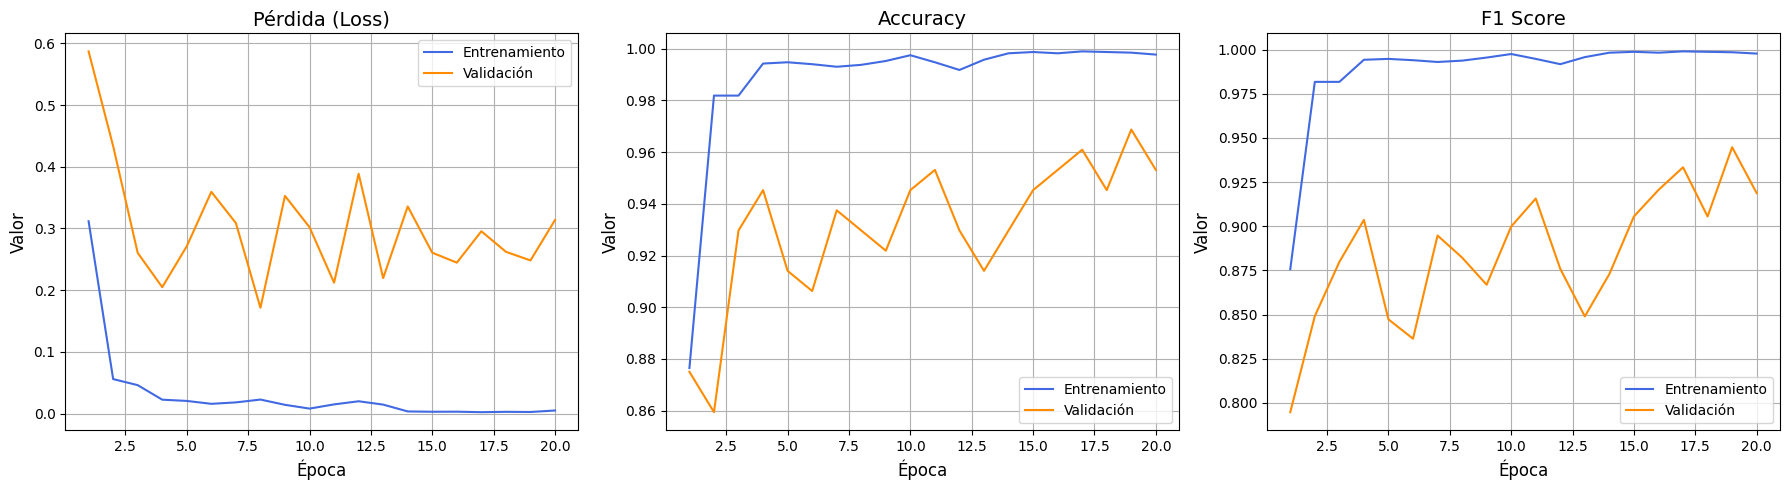

In [10]:
plot_train_results_from_json(json_file='data/resnet50_layer4_fc_train_results.json')

Resultados guardados en data/resnet50_layer4_fc_evaluation_results.json


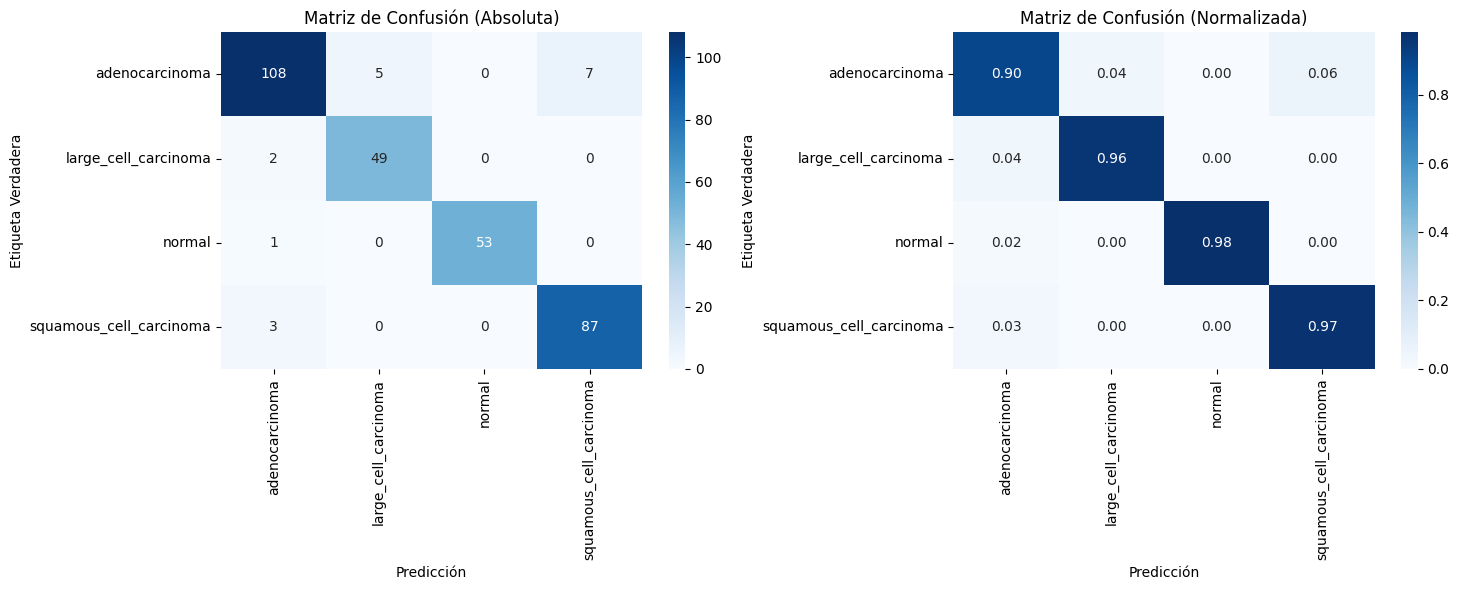

In [11]:
evaluate_model(model, test_loader, test_dataset.classes, device, output_file='data/resnet50_layer4_fc_evaluation_results.json')